In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetV2S
from tensorflow.keras import layers, models

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset_dir = "/kaggle/input/plant-diseases-training-dataset/data"
test_dir = "/kaggle/input/plant-disease-test-dataset/data"

class_samples = {class_name: len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in os.listdir(dataset_dir)}
classes_to_remove = [class_name for class_name, num_samples in class_samples.items() if num_samples < 500]
test_samples = [class_name for class_name in os.listdir(test_dir)]
train_samples = [class_name for class_name in os.listdir(dataset_dir)]

input_size = (224, 224)

batch_size = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=10,
    vertical_flip=True,
    validation_split=0.2,
    featurewise_center=True,  
    samplewise_center=True,   
    featurewise_std_normalization=True,  
    samplewise_std_normalization=True,   
)


train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    classes=[class_name for class_name in os.listdir(dataset_dir) if class_name not in classes_to_remove and class_name in test_samples]
)

validation_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    classes=[class_name for class_name in os.listdir(dataset_dir) if class_name not in classes_to_remove and class_name in test_samples],
    shuffle=False
)

test_data_gen = ImageDataGenerator(rescale = 1./255)
test_ds = test_data_gen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    classes=[class_name for class_name in os.listdir(test_dir) if class_name not in classes_to_remove and class_name in train_samples],
    shuffle=False
)

Found 35958 images belonging to 25 classes.
Found 8980 images belonging to 25 classes.
Found 1999 images belonging to 25 classes.


In [3]:
class_indices = train_ds.class_indices
samples_per_class = train_ds.classes
num_samples = {class_label: sum(samples_per_class == class_idx) for class_label, class_idx in class_indices.items()}
for class_label, num_sample in num_samples.items():
    print(f"{class_label} : {num_sample}")


Corn___northern_leaf_blight : 788
Tomato___late_blight : 1528
Tomato___healthy : 1273
Grape___healthy : 1044
Soybean___healthy : 4072
Squash___powdery_mildew : 1468
Tomato___leaf_curl : 4286
Tomato___early_blight : 800
Tomato___septoria_leaf_spot : 1417
Apple___scab : 978
Tomato___bacterial_spot : 1702
Corn___gray_leaf_spot : 411
Rice___brown_spot : 1280
Blueberry___healthy : 1202
Bell_pepper___bacterial_spot : 798
Bell_pepper___healthy : 1183
Potato___late_blight : 1616
Corn___common_rust : 954
Apple___healthy : 2056
Grape___black_rot : 944
Tomato___spider_mites : 1341
Potato___early_blight : 2103
Rice___bacterial_blight : 1268
Tomato___leaf_mold : 762
Cherry___healthy : 684


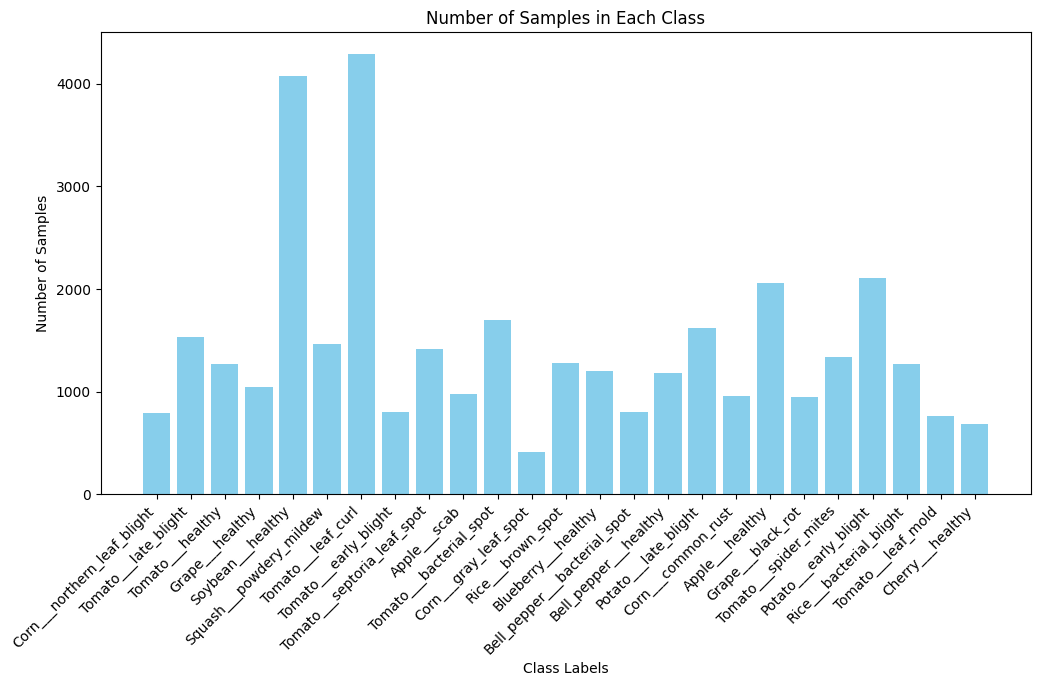

In [5]:
plt.figure(figsize=(12, 6))
plt.bar(num_samples.keys(), num_samples.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [6]:
class_indices = test_ds.class_indices
samples_per_class = test_ds.classes
num_samples = {class_label: sum(samples_per_class == class_idx) for class_label, class_idx in class_indices.items()}
for class_label, num_sample in num_samples.items():
    print(f"{class_label}: {num_sample}")


Corn___northern_leaf_blight: 176
Tomato___late_blight: 109
Tomato___healthy: 62
Grape___healthy: 63
Soybean___healthy: 62
Squash___powdery_mildew: 126
Tomato___leaf_curl: 68
Tomato___early_blight: 78
Tomato___septoria_leaf_spot: 134
Apple___scab: 77
Tomato___bacterial_spot: 95
Corn___gray_leaf_spot: 62
Rice___brown_spot: 30
Blueberry___healthy: 108
Bell_pepper___bacterial_spot: 57
Bell_pepper___healthy: 56
Potato___late_blight: 101
Corn___common_rust: 108
Apple___healthy: 86
Grape___black_rot: 57
Tomato___spider_mites: 2
Potato___early_blight: 112
Rice___bacterial_blight: 40
Tomato___leaf_mold: 75
Cherry___healthy: 55


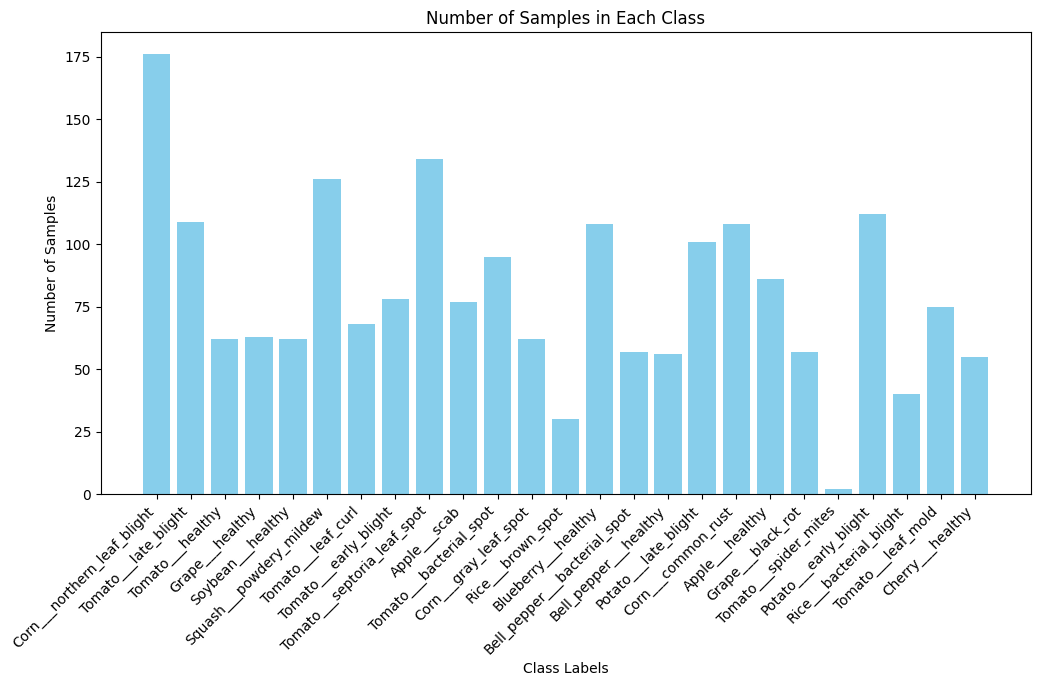

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(num_samples.keys(), num_samples.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [9]:
train_class_labels = list(train_ds.class_indices.keys())
num_classes = len(train_class_labels)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers[-2:]:
    layer.trainable = True

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [10]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
#----------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [13]:
true_labels = validation_ds.classes
class_indices = np.unique(true_labels)

class_weights = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(true_labels), 
    y = true_labels)
class_weights = dict(enumerate(class_weights))

#------------------------------------------------

epochs = 20
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[early_stopping],
    class_weight=class_weights
)

/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
1124/1124 [==============================] - 887s 754ms/step - loss: 1.9887 - accuracy: 0.3991 - val_loss: 1.5801 - val_accuracy: 0.5286
Epoch 2/20
1124/1124 [==============================] - 700s 623ms/step - loss: 0.9246 - accuracy: 0.7119 - val_loss: 1.0191 - val_accuracy: 0.6586
Epoch 3/20
1124/1124 [==============================] - 721s 641ms/step - loss: 0.5168 - accuracy: 0.8426 - val_loss: 0.5241 - val_accuracy: 0.8433
Epoch 4/20
1124/1124 [==============================] - 714s 635ms/step - loss: 0.3683 - accuracy: 0.8922 - val_loss: 0.5782 - val_accuracy: 0.8493
Epoch 5/20
1124/1124 [==============================] - 727s 647ms/step - loss: 0.2882 - accuracy: 0.9158 - val_loss: 0.4177 - val_accuracy: 0.8732
Epoch 6/20
1124/1124 [==============================] - 725s 645ms/step - loss: 0.2266 - accuracy: 0.9321 - val_loss: 0.1375 - val_accuracy: 0.9571
Epoch 7/20
1124/1124 [==============================] - 730s 649ms/step - loss: 0.1949 - accuracy: 0.9440 - val_

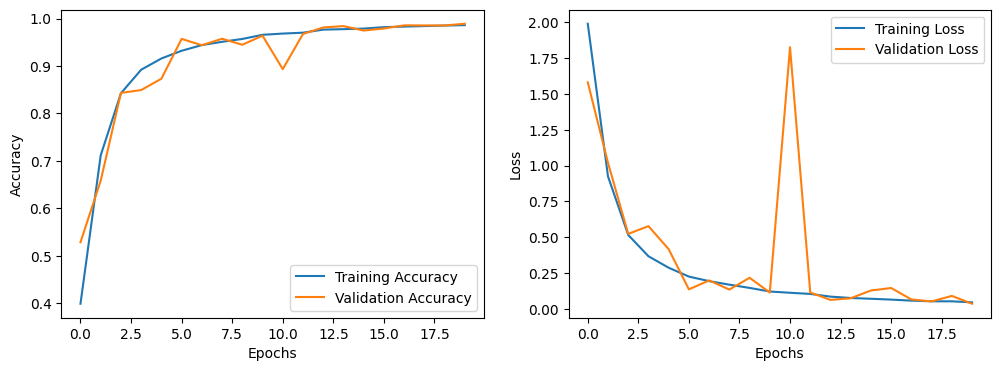

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_ds.classes

print(classification_report(true_labels, predicted_labels, sample_weight=np.array([class_weights[i] for i in true_labels])))


281/281 [==============================] - 125s 442ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96 359.20000000000175
           1       0.98      0.98      0.98 359.1999999999979
           2       1.00      1.00      1.00 359.1999999999988
           3       1.00      0.98      0.99 359.2000000000008
           4       0.98      0.99      0.99 359.20000000000255
           5       1.00      1.00      1.00 359.19999999999845
           6       1.00      0.99      0.99 359.1999999999999
           7       0.97      1.00      0.98 359.19999999999925
           8       0.99      0.99      0.99 359.2000000000014
           9       1.00      0.99      1.00 359.20000000000084
          10       0.99      0.99      0.99 359.1999999999976
          11       0.95      0.97      0.96 359.19999999999965
          12       1.00      1.00      1.00 359.2000000000006
          13       0.99      1.00      0.99 359.2000000000026
          14

In [16]:
predictions = model.predict(validation_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = validation_ds.classes

print(classification_report(true_labels, predicted_labels))

63/63 [==============================] - 49s 772ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.10      0.49      0.17       109
           2       0.00      0.00      0.00        62
           3       1.00      0.02      0.03        63
           4       0.00      0.00      0.00        62
           5       0.00      0.00      0.00       126
           6       0.07      0.66      0.13        68
           7       0.00      0.00      0.00        78
           8       0.00      0.00      0.00       134
           9       0.00      0.00      0.00        77
          10       0.05      0.08      0.06        95
          11       0.13      0.29      0.18        62
          12       0.00      0.00      0.00        30
          13       0.15      0.08      0.11       108
          14       0.00      0.00      0.00        57
          15       0.00      0.00      0.00        56
          16       0.02  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


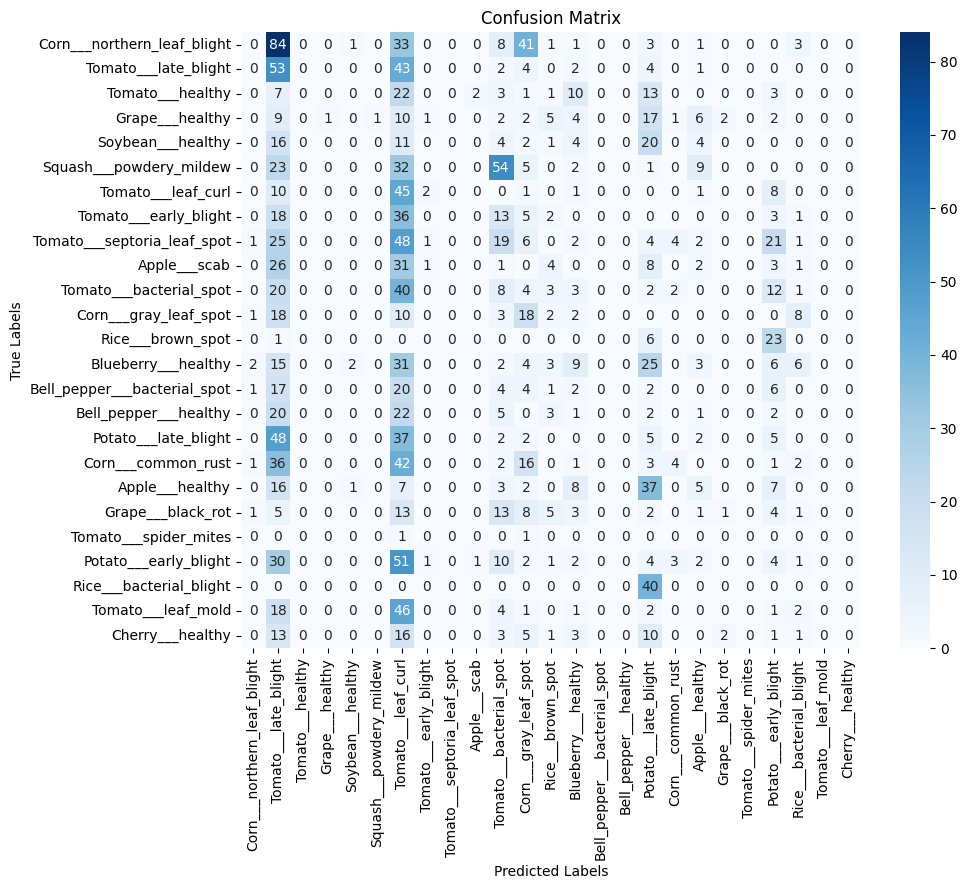

In [17]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=train_class_labels, yticklabels=train_class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
model.save("resnet.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
